In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt



## Zeitserie erstellen

In [ ]:
def generate_time_eries(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # Welle 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # Welle 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # Rauschen
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_eries(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
# model = keras.models.Sequential([
#     keras.layers.Flatten(input=(50, 1)),
#     keras.layers.Dense(1)
# ])

# model.compile(loss="mse", optimizer="adam")
# model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


### Das einfachste RNN das man bauen könnte

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

---------------------------------------------------------------------------

# Mehrere Zeitschritte vorhersagen

In [ ]:
series = generate_time_eries(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:, n_steps:]




# Recurrent Neural Network

## Vorhersage des DAX Kurses

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv("data/raw/^GDAXI.csv")
data.head()

In [ ]:
print(data.describe())
data.isna().sum()

In [ ]:
data.isna().sum()
data = data.dropna()
data

In [ ]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

In [ ]:
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

In [ ]:
length_train

In [ ]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

In [ ]:
dataset_train = train_data.Open.values
dataset_train.shape

In [ ]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

In [ ]:

scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [ ]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

In [ ]:
X_train[0]


In [ ]:
y_train[0]

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Input

# initializing the RNN
regressor = Sequential()

# defining the input shape
regressor.add(Input(shape=(X_train.shape[1], 1)))

# adding first RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# adding second RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# adding third RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# adding fourth RNN layer and dropout regularization
regressor.add(SimpleRNN(units=50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units=1))

# compiling RNN
regressor.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs=50, batch_size=32)


In [ ]:
history.history["loss"]

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [ ]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

In [ ]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

In [ ]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [ ]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

In [ ]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

In [ ]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [ ]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

In [ ]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [ ]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

In [ ]:
y_train = scaler.fit_transform(y_train)

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

In [ ]:
data.iloc[-1]

In [ ]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

In [ ]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("data/raw/^GDAXI.csv")
data.head()

In [ ]:
print(len(data))
X_var = data[["Open","Close"]]
train_slider = 60
validation_slider = 20
n_steps= 50

X_train, y_train = data[["Open","Close"]][:int(len(data)*train_slider/100)], data["Date"][:int(len(data)*train_slider/100)]
X_val, y_val = data[["Open","Close"]][:int(len(data)*validation_slider/100)], data["Date"][:int(len(data)*validation_slider/100)]
print(data.shape,X_train.shape, y_train.shape)
print(data.shape,X_val.shape, y_val.shape)

In [ ]:
y_train = pd.to_datetime(y_train)
y_train.dtype

In [ ]:
X_train

In [ ]:
dataset_train = X_train.Open
dataset_train

In [ ]:
import numpy as np
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("data/raw/^GDAXI.csv")
data.head()

In [ ]:
print(len(data))
X_var = data[["Open","Close"]]
train_slider = 60
validation_slider = 20
n_steps= 50

X_train, y_train = data[["Open","Close"]][:int(len(data)*train_slider/100), :n_steps], data["Date"][:int(len(data)*train_slider/100), -1]
X_val, y_val = data[["Open","Close"]][:int(len(data)*validation_slider/100)], data["Date"][:int(len(data)*validation_slider/100)]
print(data.shape,X_train.shape, y_train.shape)
print(data.shape,X_val.shape, y_val.shape)

# https://github.com/bnsreenu/python_for_microscopists/blob/master/166a-Intro_to_time_series_Forecasting_using_LSTM.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

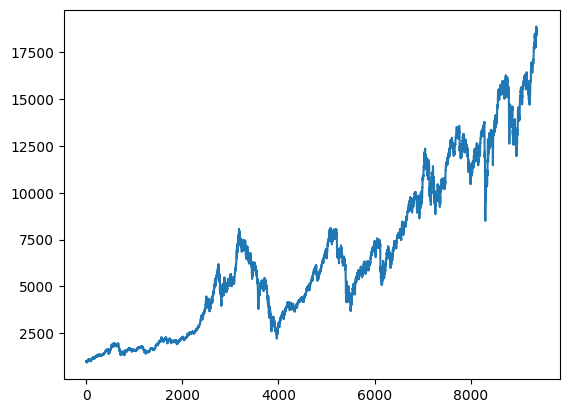

In [2]:
dataframe = pd.read_csv("data/raw/^GDAXI.csv", usecols=[1])
dataframe = dataframe.dropna()
plt.plot(dataframe)

In [3]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
print(dataset.dtype)
dataset = dataset.astype('float32') #COnvert values to float
print(dataset.dtype)


float64
float32


In [4]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [7]:
seq_size = 15  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (6064, 15)
Shape of test set: (3117, 15)


In [9]:
trainX.shape#[0]
#trainX.shape[1]

(6064, 15)

In [10]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()
print('Train...')

Single LSTM with hidden Dense...


/Users/riccardo/Desktop/Github/Bachelor/rnn/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,593 (88.25 KB)

 Trainable params: 22,593 (88.25 KB)

 Non-trainable params: 0 (0.00 B)

Train...


In [ ]:
help(Sequential)

In [12]:
model.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=20)


Epoch 1/20
190/190 - 1s - 5ms/step - loss: 0.0010 - val_loss: 3.3988e-04
Epoch 2/20
190/190 - 0s - 850us/step - loss: 6.0445e-05 - val_loss: 2.5875e-04
Epoch 3/20
190/190 - 0s - 826us/step - loss: 5.2772e-05 - val_loss: 3.0681e-04
Epoch 4/20
190/190 - 0s - 816us/step - loss: 4.6170e-05 - val_loss: 4.0782e-04
Epoch 5/20
190/190 - 0s - 832us/step - loss: 3.8888e-05 - val_loss: 2.2665e-04
Epoch 6/20
190/190 - 0s - 832us/step - loss: 3.3801e-05 - val_loss: 4.9902e-04
Epoch 7/20
190/190 - 0s - 821us/step - loss: 3.1558e-05 - val_loss: 6.1740e-04
Epoch 8/20
190/190 - 0s - 832us/step - loss: 2.8443e-05 - val_loss: 4.5071e-04
Epoch 9/20
190/190 - 0s - 829us/step - loss: 2.6659e-05 - val_loss: 2.0442e-04
Epoch 10/20
190/190 - 0s - 819us/step - loss: 2.6666e-05 - val_loss: 6.6186e-04
Epoch 11/20
190/190 - 0s - 836us/step - loss: 2.6349e-05 - val_loss: 3.0303e-04
Epoch 12/20
190/190 - 0s - 813us/step - loss: 2.5752e-05 - val_loss: 4.2590e-04
Epoch 13/20
190/190 - 0s - 809us/step - loss: 2.3743e-0

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


In [14]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [23]:
trainPredict[:,0].shape, trainPredict.shape

((6064,), (6064, 1))

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 82.61 RMSE
Test Score: 435.16 RMSE


In [25]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict



In [26]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict



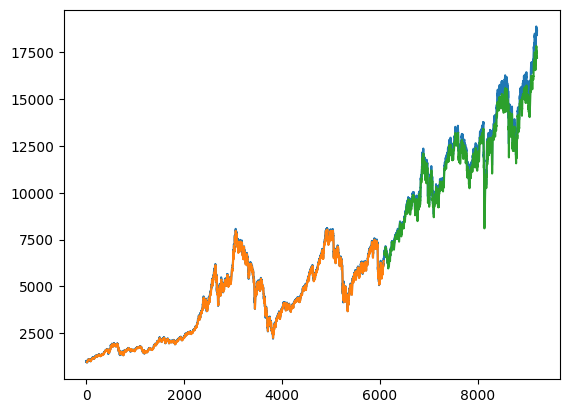

In [27]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()